The aim of this note is to describe the data and how the `benchmark.csv` submission for the competition is created. 
It also provides some code snippets for exploratory data analysis on the competition data.

## The Competition and Data

The data set for this competition is from PayJoy. The companion document (`PayJoy Prediction Project.pdf`) provides background on PayJoy, the prediciton task, and data dictionary. But in summary, we are provided with data of 50,000 approved customer loan applications during 2021 and 2022. This data set includes rich information about each application (features) and whether the customer was a poor payer of the loan or not (i.e., binary outcome).

#### Objective

PayJoy would like to predict whether each customer is poor payer or not. You are hired as a consultant to help PayJoy to build a predictive model. For every single customer (row) in the test set, you are expected to predict a probability, using the features available to you, that the customer will be a poor payer (outcome = 1, or equivalently the target metric `metric_locked_percent_first_114_lockable_days_v1` is above 0.7). Your prediction will be a probability $p$ between $0$ an $1$.


#### Evaluation metric

The metric that will be used to evaluate your predictions is **area under ROC curve (AUC)** which was discussed in detail in class (see Lecture 5). A short intuitive definition of AUC is the fraction of all pairs of customers (A,B) where A is poor payer and B is not, but A receives a probability $p$ greater than B.

The leaderboard score will be evaluated based solely on the AUC generated on 25% of the test set (public test set). However, your final submission will be evaluated using the remaining 75% of the bookings in the test set (private test set). This separation is performed randomly and will not be disclosed to you in order to prevent leakage of information from the results of daily submissions. However, your score on both sets will be very close due to large sample sizes and random partitioning.

#### Data

The data files are in comma delimited format. 

**Training data:** The training dataset `training.csv` contains contains 25,000
rows, each row corresponding to a customer loan. Training set contains 1,324 columns. The first/header row of the data set contains the field names. The columns are described in the companion document.

 **Test data:** The test dataset `test.csv` contains 25,000 rows and 1,323 columns. The first/header row of the data set contains the column names. The test data contains all. The columns in the test dataset are identical to the columns in the training dataset except that the values for the target metci `metric_locked_percent_first_114_lockable_days_v1` are removed.

The companion document (`PayJoy Prediction Project.pdf`) explains the columns in detail. The training and test set are 50-50 chronological split of the data. Specifically, we have a total of 50K rows with the older 25K row placed in the training and the more recent 25K row are in the test.

**File descriptions**

 - `training.csv` - the training set 
 - `test.csv` - the test set
 - `sample_submission.csv` - a sample submission file in the correct
   format 
 - `Prediction Challenge, Notes and Benchmark.ipynb` - this notebook.


## Benchmark code

Here, we build a a simple logistic regression and make predictions for the `test` set. 
Then a submission file is generated that contains the prediciton (to upload on Kaggle website).

We start with the the standard setup. 

In [56]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

Next, you need to download `training.csv` and `test.csv` (from Kaggle.com or from Canvas) and save them in your local computer. Then, use the following cell to read the data. You may need to update the path for reading the files.

In [221]:
training = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")


/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_10033/928616564.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  training = pd.read_csv("training.csv")
/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_10033/928616564.py:2: DtypeWarning: Columns (28,139) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv")


Now, we will need to plan for preprocessing/cleaning of the data. <font color='#E63615'>It is a very important rule in machine learning that preprocessing of the data should be equally applied to both the training and the test set (i.e., do NOT clean/preprocess the training and test data separately).</font> Therefore, we need to create a single data frame containing both data sets. However, The training set has an extra column compared to the test set, `metric_locked_percent_first_114_lockable_days_v1`. First, we create a placeholder for the variable `metric_locked_percent_first_114_lockable_days_v1` in the test set. We just fill it with all zeros since it does not matter what it contains, it will not be used in our analysis. The true value for the `metric_locked_percent_first_114_lockable_days_v1` column in the test set is used by Kaggle to evaluate our submissions, and is not revealed to us before the competition ends. 

In [222]:
test['metric_locked_percent_first_114_lockable_days_v1'] = np.zeros(len(test))
test.head()

,finance_order_id,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,...,credit_account_count_payment_frequency_monthly_mx_v1,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,metric_locked_percent_first_114_lockable_days_v1
0,2025000,1652489606,85.0,4.0,19.0,647.0,131.0,0.000000,0.0,0.0,...,1,0,0,0,1,1,1,1,0,0.0
1,2025001,1652489786,232.0,16.0,55.0,249.0,131.0,0.272727,0.0,0.0,...,2,0,1,0,2,3,2,1,0,0.0
2,2025002,1652489833,52.0,6.0,12.0,297.0,132.0,0.000000,0.0,0.0,...,3,0,0,0,3,7,6,2,0,0.0
3,2025003,1652490225,160.0,6.0,16.0,506.0,131.0,0.000000,0.0,0.0,...,4,0,0,0,2,4,7,2,0,0.0
4,2025004,1652490259,24.0,0.0,1.0,302.0,140.0,1.000000,NaN,NaN,...,7,0,0,0,3,5,6,2,0,0.0


Now, we use the `append` command to stack the training and the test set on top of each other. This procedure is only allowed when the column names and their order in the two data frames match.

In [224]:
all_data = training.append(test, ignore_index=True)
all_data.head()
all_data.shape

/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_10033/1905473018.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = training.append(test, ignore_index=True)


(50000, 1324)

### Preprocessing

Now, we can preprocess the `all_data` data frame. You can potentially do a lot of work in this stage. But for now, we only do few basic things. First, we create a variable called outcome, and remove `metric_locked_percent_first_114_lockable_days_v1` and `finance_order_id` column since they should not be used in the model building.

In [236]:
all_data['outcome'] = (all_data['metric_locked_percent_first_114_lockable_days_v1']>0.7).astype(int)
all_data = all_data.drop(columns=['finance_order_id','metric_locked_percent_first_114_lockable_days_v1'])
all_data.head()

,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,weekend,outcome
0,1639665815,93.0,2.0,15.0,435.0,281.0,0.166667,0.000000,0.000000,0.000000,...,0,0,0,1,1,1,0,0,0,0
1,1639666973,636.0,45.0,176.0,492.0,279.0,0.023256,0.000000,0.021277,0.000000,...,0,0,0,1,1,1,0,0,0,0
2,1639667578,386.0,19.0,54.0,568.0,279.0,0.083333,0.000000,0.000000,0.022222,...,0,0,0,2,2,2,1,0,0,0
3,1639671052,15.0,4.0,15.0,295.0,280.0,0.000000,0.000000,0.000000,NaN,...,0,0,0,2,3,2,1,0,0,1
4,1639671273,1263.0,30.0,104.0,964.0,279.0,0.151515,0.090909,0.000000,0.000000,...,0,0,0,3,3,3,2,0,0,0


Now we are going to do a sample feature engineering. We create a binary variable that measures whether the loan application was published during Friday through Sunday.

In [237]:
all_data['weekend'] = all_data['time_day_of_week_v1'].apply(lambda x: x in [5,6,7]).astype(int)

all_data.describe()


,application_time,clerk_loan_count_total_v1,clerk_loan_count_last_7_days_v1,clerk_loan_count_last_28_days_v1,clerk_loan_days_since_first_v1,clerk_loan_days_since_last_v1,clerk_fpd_1_last_7_mature_days_v1,clerk_fpd_3_last_7_mature_days_v1,clerk_fpd_7_last_14_mature_days_v1,clerk_fpd_15_last_28_mature_days_v1,...,credit_account_count_payment_frequency_biweekly_mx_v1,credit_account_count_payment_frequency_bimonthly_mx_v1,credit_account_count_payment_frequency_annually_mx_v1,credit_account_count_distinct_account_type_mx_v1,credit_account_count_distinct_credit_type_mx_v1,credit_account_count_distinct_creditor_mx_v1,credit_account_count_distinct_warning_mx_v1,credit_account_count_creditor_motorcyle_finance_company_mx_v1,weekend,outcome
count,5.000000e+04,46724.000000,46724.000000,46724.000000,46724.00000,46724.000000,38372.000000,37792.000000,39685.000000,38990.00000,...,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.652525e+09,152.871822,5.431213,20.637060,356.58165,137.443348,0.087243,0.044379,0.021347,0.01043,...,0.478240,0.103700,0.01100,1.912380,2.909840,3.334840,1.487000,0.000460,0.467140,0.090620
std,7.852056e+06,255.316613,7.627657,26.009882,273.21521,89.199036,0.170031,0.123194,0.070938,0.03782,...,1.902093,0.353141,0.19514,1.178206,2.075302,2.621332,1.351395,0.022356,0.498924,0.287071
min,1.639666e+09,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.645572e+09,17.000000,1.000000,6.000000,178.00000,56.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.652490e+09,57.000000,3.000000,13.000000,293.00000,136.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,2.000000,3.000000,3.000000,1.000000,0.000000,0.000000,0.000000
75%,1.659542e+09,173.000000,7.000000,26.000000,456.00000,215.000000,0.125000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.00000,3.000000,4.000000,5.000000,2.000000,0.000000,1.000000,0.000000
max,1.666061e+09,2729.000000,167.000000,425.000000,2053.00000,1123.000000,1.000000,1.000000,1.000000,1.00000,...,70.000000,10.000000,16.00000,6.000000,12.000000,17.000000,9.000000,2.000000,1.000000,1.000000


#### Handling missing values

The next step is, to notice that a large number of variables have missing values. In fact, the following code shows variables with no missing values.

In [378]:
all_data.columns[all_data.isna().mean()==0.0]

all_data.fillna(0,inplace=True)

Below, we will only use variables that have no missing values, but one should also be able to leverage the variables with missing values using impuation methods.

### Model building phase

Now, we are ready to build a model. First, we need to partition the processed data to training and test. As long as we do not permute the rows of `all_data` in our preprocessing, the order of observations in the new training and test set, constructed below, will be the same as the original files.

In [379]:
training_processed = all_data.iloc[0:len(training),:]
test_processed = all_data.iloc[len(training):len(all_data),:]
print(training_processed.shape)
print(test_processed.shape)

(25000, 1324)
(25000, 1324)


Then, we use `sm.glm` to build a logistic regression, using only two variables, `device_model_first_sale_time_months_since_v1` and `weekend`. And then use this model to predict on the test set.

In [383]:
myformula = 'outcome ~ device_model_first_sale_time_months_since_v1+weekend'
model = smf.glm(formula= myformula ,data=training_processed, family=sm.families.Binomial()).fit()

test_predictions = model.predict(test_processed)

### Preparing a submission file

Now that we have a prediction for each row of the test set, we can write that into a submission file to upload to Kaggle website.

In [381]:
submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = test_predictions.reset_index(drop=True)
submission.to_csv("benchmark.csv",index = False)
submission.head()

,Id,Predicted
0,2025000,0.168149
1,2025001,0.168149
2,2025002,0.166169
3,2025003,0.174203
4,2025004,0.223881


Next, we perform a visual inspection to confirm that our predictions are indeed between 0 and 1.

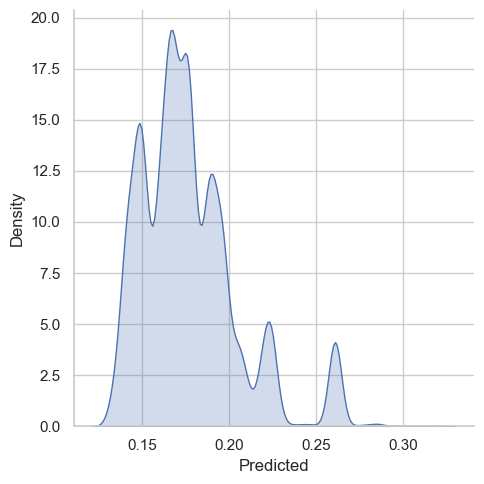

In [382]:
sns.displot(x='Predicted',data=submission,kind="kde", fill=True)
plt.show();

### Making the submission

At this point, you can try to submit the file `benchmark.csv` on Kaggle website. You should see that the public leader board score of this submission is `AUC = 0.53160`

## Additional Notes on Preliminary Assessment of Our Models, without Submitting on Kaggle

Given that each team has a limited number of submissions per day on Kaggle, we need to have our own mock test set, in ordero to rapidly test and compare different models. First, we split the training data into mock_training and mock_test data.

In [384]:
n_mock_training = int(len(training_processed)*0.7)

mock_training = training_processed.iloc[0:n_mock_training,:]
mock_test = training_processed.iloc[n_mock_training:len(training_processed),:]

mock_training.shape



(17500, 1324)

Now, we build the same model as above on `mock_training` and evaluate it on `mock_test`

In [243]:
mock_model = smf.glm(formula= myformula ,data=mock_training, family=sm.families.Binomial()).fit()
print(mock_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                17500
Model:                            GLM   Df Residuals:                    17497
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8149.0
Date:                Sat, 18 Feb 2023   Deviance:                       16298.
Time:                        07:25:06   Pearson chi2:                 1.75e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002747
Covariance Type:            nonrobust                                         
                                                   coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

Now, we use this model to predict for each row of the the mock test set and evalute the AUC.

In [386]:
mock_test_predictions = mock_model.predict(mock_test)

mock_auc = roc_auc_score(mock_test['outcome'], mock_test_predictions)
print('AUC of the mock logistic regression on the mock_test set is',mock_auc)

AUC of the mock logistic regression on the mock_test set is 0.538769271016665


## Test a tree model

We can now try to see how much this is better than, if we use a tree model with the same two variables as in `myformula`.

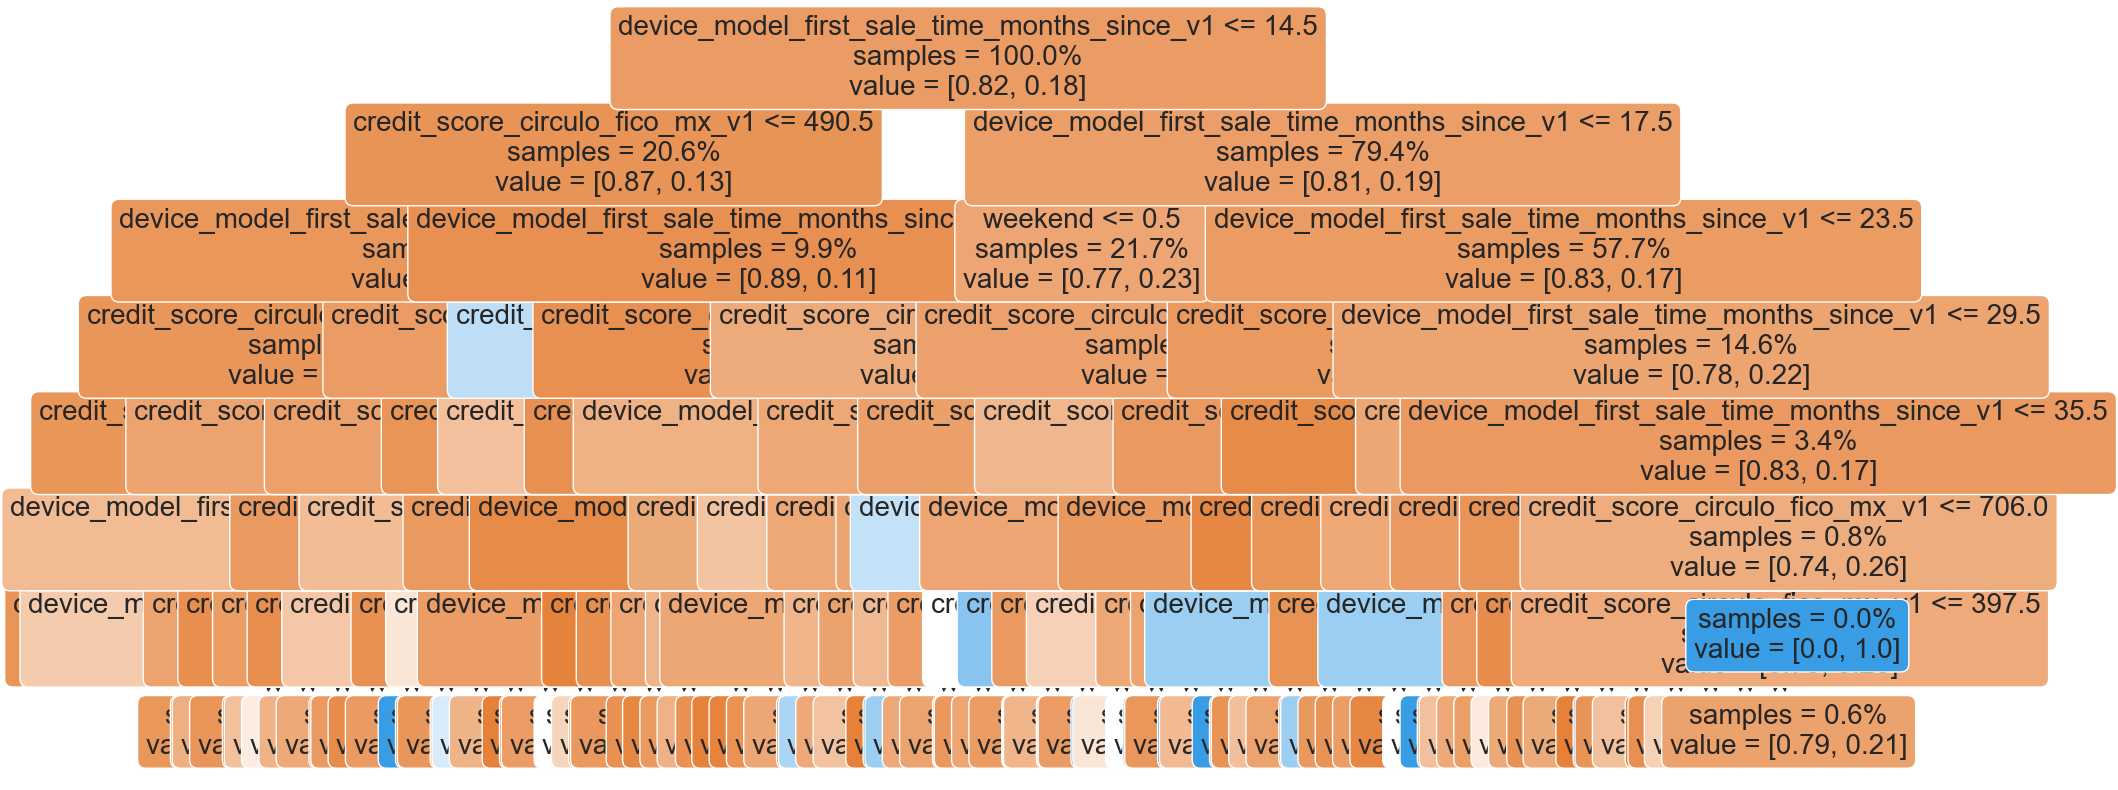

In [387]:
tree_depth = 7

features = ['device_model_first_sale_time_months_since_v1','weekend','credit_account_count_creditor_motorcyle_finance_company_mx_v1','credit_score_circulo_fico_mx_v1']

mock_model_tree = DecisionTreeClassifier(max_depth= tree_depth).fit(mock_training.loc[:,features],
                                                              mock_training['outcome'])

plt.figure(figsize=(20,10))
plot_tree(mock_model_tree
          ,max_depth =tree_depth
          ,feature_names=features
          ,proportion=True,fontsize=20 
          ,impurity = False
          ,rounded = True
          ,precision = 2
          ,filled = True
         )
plt.show();

In [245]:
mock_test_predictions_tree = mock_model_tree.predict_proba(mock_test.loc[:,features])[:,1]

mock_auc_tree = roc_auc_score(mock_test['outcome'], mock_test_predictions_tree)
print('AUC of the mock tree on the mock_test set is',mock_auc_tree)

AUC of the mock tree on the mock_test set is 0.5758764886313796


As we see, the tree has a much better AUC than the logistic regression and we would may benefit by using this tree.

In [405]:
# Separate Target Variable and Predictor Variables
TargetVariable=['outcome']
features=['device_model_first_sale_time_months_since_v1','weekend','device_model_first_sale_time_months_since_v1','device_model_first_sale_time_months_since_v1',
       'credit_inquiry_count_type_unsecured_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_score_circulo_fico_mx_v1',
       'clerk_loan_count_total_v1',
       'merchant_loan_count_total_v1',
       'credit_utilization_max_updated_last_6_months_mx_v1',
       'credit_payment_days_since_last_mx_v1',
       'credit_limit_total_type_bank_card_updated_last_6_months_mx_v1',
       'credit_limit_max_type_bank_card_mx_v1',
       'credit_limit_max_mx_v1',
       'credit_limit_min_mx_v1',
       'credit_inquiry_days_since_last_type_unknown_mx_v1',
       'credit_inquiry_days_since_last_type_personal_loan_mx_v1',
       'credit_inquiry_days_since_last_type_installment_mx_v1',
       'credit_inquiry_days_since_last_creditor_sic_mx_v1',
       'credit_inquiry_days_since_last_creditor_bank_mx_v1',
       'credit_delinquent_periods_total_mx_v1'
       ]      

X=mock_training.loc[:,features]
y=mock_training['outcome']

# Use GBC to predict the outcome
from sklearn.ensemble import GradientBoostingClassifier

modelGBM = GradientBoostingClassifier(n_estimators=100) #n_estimators denotes the number of trees that are constructed
modelGBM.fit(X,y)
validationProbsGBM  = modelGBM.predict_proba(mock_test.loc[:,features])[:,1]

print('AUC of GBM model is',roc_auc_score(mock_test['outcome'], validationProbsGBM),'\n')

probsGBM=modelGBM.predict_proba(test_processed.loc[:,features])[:,1]

print(probsGBM)

AUC of GBM model is 0.5761228978786812 

[0.17831691 0.13781146 0.15024789 ... 0.14585795 0.16118027 0.16118027]


In [404]:
submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsGBM
submission.to_csv("benchmarkGBM.csv",index = False)
submission.head()

,Id,Predicted
0,2025000,0.156952
1,2025001,0.112478
2,2025002,0.118512
3,2025003,0.118911
4,2025004,0.380062


In [368]:
# Separate Target Variable and Predictor Variables
TargetVariable=['outcome']
features=['device_model_first_sale_time_months_since_v1','device_model_first_sale_time_months_since_v1','device_model_first_sale_time_months_since_v1',
       'credit_inquiry_count_type_unsecured_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_2_last_1_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_6_months_mx_v1',
       'credit_inquiry_count_type_unsecured_loan_1_last_1_months_mx_v1',
       'credit_score_circulo_fico_mx_v1'
       ] 

X=training_processed.loc[:,features]
y=training_processed[TargetVariable].values


### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#print first 10 rows of X_train

(17500, 17)
(17500, 1)
(7500, 17)
(7500, 1)


In [369]:
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
classifier.add(Dense(units=10, input_dim=17, kernel_initializer='uniform', activation='relu'))

#Defining the SECOND hidden layer, here we have not defined input because it is
# second layer and it will get input as the output of first hidden layer
classifier.add(Dense(units=10, kernel_initializer='uniform', activation='relu'))

# Defining the Output layer
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
# And output_dim will be equal to the number of factor levels
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Optimizer== the algorithm of SGG to keep updating weights
# loss== the loss function to measure the accuracy
# metrics== the way we will compare the accuracy after each step of SGD
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fitting the Neural Network on the training data
ANN_Model=classifier.fit(X_train,y_train, batch_size=100 , epochs=10, verbose=1)

Epoch 1/10


2023-02-19 00:34:05.386580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - 2s 6ms/step - loss: 0.6456 - accuracy: 0.8191
Epoch 2/10
175/175 [==============================] - 1s 6ms/step - loss: 0.5257 - accuracy: 0.8202
Epoch 3/10
175/175 [==============================] - 1s 5ms/step - loss: 0.4762 - accuracy: 0.8202
Epoch 4/10
175/175 [==============================] - 1s 5ms/step - loss: 0.4713 - accuracy: 0.8202
Epoch 5/10
175/175 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.8202
Epoch 6/10
175/175 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.8202
Epoch 7/10
175/175 [==============================] - 1s 6ms/step - loss: 0.4711 - accuracy: 0.8202
Epoch 8/10
175/175 [==============================] - 1s 5ms/step - loss: 0.4712 - accuracy: 0.8202
Epoch 9/10
175/175 [==============================] - 1s 6ms/step - loss: 0.4712 - accuracy: 0.8202
Epoch 10/10
175/175 [==============================] - 1s 5ms/step - loss: 0.4712 - accuracy: 0.8202


In [371]:
validationProbsANN  = classifier.predict(X_test)

print('AUC of ANN model is',roc_auc_score(y_test, validationProbsANN),'\n')

X=test_processed.loc[:,features]

### Sandardization of data ###
### We does not standardize the Target variable for classification
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)

probsANN=classifier.predict(X)

submission = pd.DataFrame(columns = ['Id', 'Predicted'])
submission['Id'] = test['finance_order_id'].reset_index(drop=True)  # matching the id's of the test set, valid as long as we never permuted rows of the data
submission['Predicted'] = probsANN
submission.to_csv("benchmarkANN.csv",index = False)
submission.head()

235/235 [==============================] - 0s 2ms/step
AUC of ANN model is 0.5 

782/782 [==============================] - 2s 2ms/step


,Id,Predicted
0,2025000,0.179783
1,2025001,0.179783
2,2025002,0.179783
3,2025003,0.179783
4,2025004,0.179783


In [287]:
# Predictions on testing data
Predictions=classifier.predict(X_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

# Generating a data frame for analyzing the test data
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Credit']=y_test
TestingData['PredictedCredit']=Predictions

# Defining the probability threshold
def probThreshold(inpProb):
    if inpProb  >  0.7:
        return(1)
    else:
        return(0)

# Generating predictions on the testing data by applying probability threshold
TestingData['PredictedCredit']=TestingData['PredictedCredit'].apply(probThreshold)

###############################################
from sklearn import metrics
print('\n######### Testing Accuracy Results #########')
print(metrics.classification_report(TestingData['Credit'], TestingData['PredictedCredit']))
print(metrics.confusion_matrix(TestingData['Credit'], TestingData['PredictedCredit']))


235/235 [==============================] - 1s 2ms/step

######### Testing Accuracy Results #########
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      6116
           1       0.00      0.00      0.00      1384

    accuracy                           0.82      7500
   macro avg       0.41      0.50      0.45      7500
weighted avg       0.66      0.82      0.73      7500

[[6116    0]
 [1384    0]]


/Users/sebage/opt/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebage/opt/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sebage/opt/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le